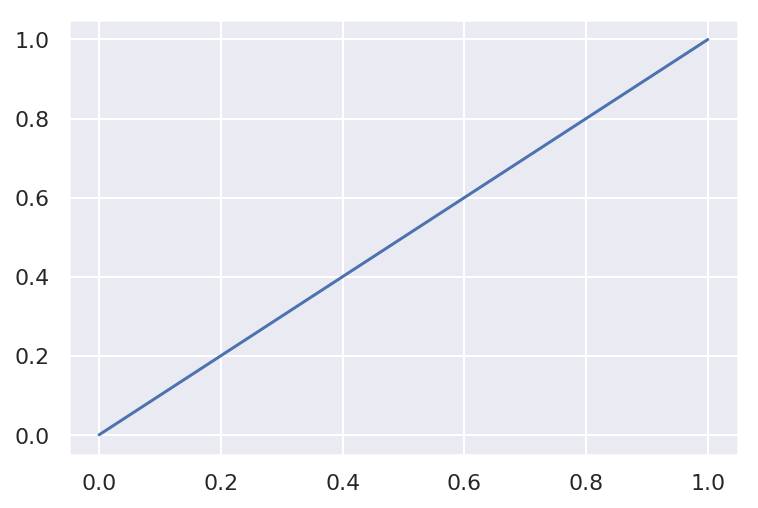

In [0]:
import torch
import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%config InlineBackend.figure_format = 'retina'

plt.plot([0, 1])
plt.show()

pop_size=1024

In [0]:
lin1 = nn.Linear(4, 3, bias=False)
lin2 = nn.Linear(4, 3, bias=False)

In [0]:
X = torch.randn((3, 2, 4))
w = torch.randn((3, 3, 4))
lin1.weight.data = w[0]
lin2.weight.data = w[1]
with torch.no_grad():
    y1 = lin1(X[0])
    y2 = lin1(X[1])
print(y1)
print(y2)

tensor([[-1.7426,  0.7265, -0.5889],
        [ 1.2801, -1.5444, -1.7934]])
tensor([[-0.2730, -0.3672,  0.2971],
        [-0.5536,  1.2720,  0.6092]])


In [0]:
torch.einsum('pnm,pbm -> pbn', (w, X))

tensor([[[-1.7426,  0.7265, -0.5889],
         [ 1.2801, -1.5444, -1.7934]],

        [[-2.0967,  1.6622,  0.8480],
         [ 2.5429, -1.4744, -1.4262]],

        [[-0.1603,  0.5341, -0.0084],
         [-0.5517,  2.5033,  1.9845]]])

In [0]:
class PopLinear(nn.Module):
    def __init__(self, in_features, out_features, pop_size=100, bias=True, *args, **kwargs):
        super(PopLinear, self).__init__(*args, **kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.pop_size = pop_size
        self.weight = nn.Parameter(data=torch.randn((pop_size, out_features, in_features)), requires_grad=False)
        if bias:
            self.bias = nn.Parameter(data=torch.randn((pop_size, out_features)), requires_grad=False)
        else:
            self.bias = None
            
    def vectorize(self):
        w = self.weight.data.view(self.pop_size, -1)
        if self.bias is not None:
            b = self.bias.view(self.pop_size, -1)
            w = torch.cat([w, b], dim=1)
        return w
    
    def assign_vector(self, w):
        if self.bias is not None:
            b_dim = self.bias.shape[1] * -1
            slc = w[:, b_dim:]
            self.bias.data = w[:, b_dim:]
            self.weight.data = w[:, :b_dim].view(self.pop_size, self.out_features, self.in_features)
        else:
            b_dim = -1
            self.weight.data = w.reshape(self.pop_size, self.out_features, self.in_features)
        
    def forward(self, inp):
        X = torch.einsum('pnm,pbm -> pbn', (self.weight.data, inp))
        if self.bias is not None:
            X += self.bias.data[:, None, :]
        return X
    
lin3 = PopLinear(4, 3, 3, bias=False)
lin3.weight.data = w

In [0]:
vec = lin3.vectorize()
lin3.assign_vector(vec)

In [0]:
lin3(X)

tensor([[[-1.7426,  0.7265, -0.5889],
         [ 1.2801, -1.5444, -1.7934]],

        [[-2.0967,  1.6622,  0.8480],
         [ 2.5429, -1.4744, -1.4262]],

        [[-0.1603,  0.5341, -0.0084],
         [-0.5517,  2.5033,  1.9845]]])

In [0]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = load_digits(return_X_y=True)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=.1, random_state=42)

Xmean = Xtr.mean()
Xstd = Xtr.std()
Xtr -= Xmean
Xte -= Xmean
Xtr /= Xstd
Xte /= Xstd

In [0]:
class LEEAModel(nn.Module):
    def __init__(self, pop_size=100, *args, **kwargs):
        super(LEEAModel, self).__init__(*args, **kwargs)
        self.pop_size = pop_size
        self.layers = []
        self.inp = PopLinear(in_features=64, out_features=64, pop_size=pop_size)
        self.layers.append(self.inp)
        self.dense1 = PopLinear(in_features=64, out_features=64, pop_size=pop_size)
        self.layers.append(self.dense1)
        self.dense2 = PopLinear(in_features=64, out_features=64, pop_size=pop_size)
        self.layers.append(self.dense2)
        self.dense3 = PopLinear(in_features=64, out_features=10, pop_size=pop_size)
        self.layers.append(self.dense3)
        self.layer_sizes = []
        
    def vectorize(self):
        if len(self.layer_sizes) == 0:
            get_sizes = True
        else:
            get_sizes = False
        z = []
        for layer in self.layers:
            z_ = layer.vectorize()
            z.append(z_)
            if get_sizes:
                self.layer_sizes.append(z_.shape[1])
        return torch.cat(z, dim=1)
    
    def assign_vector(self, z):
        start_idx = 0
        stop_idx = 0
        for i, layer in enumerate(self.layers):
            stop_idx = start_idx + self.layer_sizes[i]
            slc = z[:, start_idx:stop_idx]
            start_idx = stop_idx
            layer.assign_vector(slc)
        
    def forward(self, inp):
        x = inp[None, :, :].expand((self.pop_size, -1, 64))
        x = torch.relu(self.inp(x))
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        out = self.dense3(x)
        return out
        
        
model = LEEAModel().cuda()

def get_fitnesses(X, y):
    out = model(X)
    res = torch.argmax(out, dim=2)
    fitnesses = (res == y).float().mean(dim=1)
    return fitnesses

def batch_generator(X, y, batch_size=128):
    X = torch.tensor(X).float().cuda()
    y = torch.tensor(y).cuda()
    dim = X.shape[0]
    while True:
        ind = torch.randint(high=dim, size=(batch_size,))
        yield X[ind], y[ind]
        
gen = batch_generator(Xtr, ytr, batch_size=512)
X_, y_ = next(gen)
fitnesses = get_fitnesses(X_, y_)

In [0]:
z = model.vectorize()
model.assign_vector(z)

In [0]:
fitnesses2 = get_fitnesses(X_, y_)

In [0]:
class LEEAOptimizer(object):
    def __init__(self, pop_size=100, sigma=0.001, alpha=1.00, pE=0.05, pC=0.50, pM=0.45, rho=0.5, device='cpu'):
        self.pop_size=pop_size
        self.sigma=sigma
        self.alpha=alpha
        self.pE=pE
        self.pC=pC
        self.pM=pM
        self.rho=rho
        self.device = device
        self.p1_fitness = torch.tensor([0.0 for _ in range(pop_size)]).to(device)
        self.p2_fitness = torch.tensor([0.0 for _ in range(pop_size)]).to(device)
        
    def update(self, model, fitnesses):
        f_prime = (((self.p1_fitness + self.p2_fitness)/2) * (1-self.alpha)) + fitnesses
        z = model.vectorize()
        next_generation = self.produce_generation(f_prime, z)
        model.assign_vector(next_generation)
        return model
    
    def generate_mutants(self, z, next_generation, p1s, p2s, f_prime, f_primes, selected):
        n_mutants = int(self.pop_size * self.pM)
        ps = f_primes
        indices = torch.multinomial(ps, num_samples=n_mutants, replacement=True)
        mutants = selected[indices]
        p1s.append(f_prime[mutants])
        p2s.append(f_prime[mutants])
        mutants = z[mutants]
        mutants = mutants + self.sigma * torch.randn(mutants.shape).to(self.device)
        next_generation = torch.cat(next_generation+[mutants], dim=0)
        return next_generation, p1s, p2s
    
    def crossover(self, p1, p2):
        cond = (torch.rand(p1.shape) < .5).float().to(self.device)
        offspring = (cond * p1) + ((1-cond) * p2)
        return offspring
        
    def generate_offspring(self, z, next_generation, p1s, p2s, f_prime, f_primes, selected):
        n_offspring = self.pop_size - next_generation.shape[0]
        ps = f_primes
        p1 = torch.multinomial(ps, num_samples=n_offspring, replacement=True)
        p1 = selected[p1]
        p2 = torch.multinomial(ps, num_samples=n_offspring, replacement=True)
        p2 = selected[p2]
        offspring = self.crossover(z[p1], z[p2])
        next_generation = torch.cat([next_generation, offspring], dim=0)
        p1s.append(f_prime[p1])
        p2s.append(f_prime[p2])
        return next_generation, p1s, p2s
        
    def produce_generation(self, f_prime, z):
        n_elites = int(self.pop_size * self.pE)
        _, elites = torch.topk(f_prime, n_elites)
        k_selected = int(self.pop_size * self.rho)
        f_primes, selected = torch.topk(f_prime, k_selected)
        next_generation = [z[elites]]
        p1s = [f_prime[elites]]
        p2s = [f_prime[elites]]
        next_generation, p1s, p2s = self.generate_mutants(z, next_generation, p1s, p2s, f_prime, f_primes, selected)
        next_generation, p1s, p2s = self.generate_offspring(z, next_generation, p1s, p2s, f_prime, f_primes, selected)
        self.p1_fitness = torch.cat(p1s)
        self.p2_fitness = torch.cat(p2s)
        return next_generation
        

model = LEEAModel(pop_size=pop_size).cuda()
optim = LEEAOptimizer(pop_size=pop_size, sigma=0.1, device='cuda:0')

gen = batch_generator(Xtr, ytr, batch_size=512)
X_, y_ = next(gen)
fitnesses = get_fitnesses(X_, y_)
optim.update(model, fitnesses)

LEEAModel(
  (inp): PopLinear()
  (dense1): PopLinear()
  (dense2): PopLinear()
  (dense3): PopLinear()
)

In [0]:
Xte = torch.tensor(Xte).float().cuda()
yte = torch.tensor(yte).cuda()

get_fitnesses(Xte, yte).max()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor(0.2444, device='cuda:0')

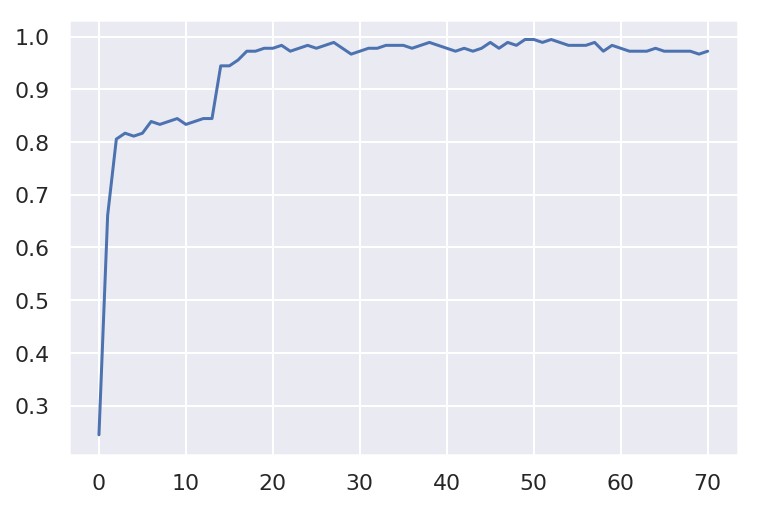

KeyboardInterrupt: ignored

In [0]:
from IPython.display import clear_output

history = []
vals = []

for i in range(100000):
    X_, y_ = next(gen)
    fitnesses = get_fitnesses(X_, y_)
    model = optim.update(model, fitnesses)
    history.append(float(fitnesses.max()))
    if i % 100 == 0:
        val_fit = get_fitnesses(Xte, yte).max()
        vals.append(val_fit)
    if i % 1000 == 0:
        clear_output()
        plt.plot(vals)
        plt.show()

In [0]:
val_fit = get_fitnesses(Xte, yte).max()
vals.append(val_fit)
plt.plot(vals)
plt.show()